In [1]:
import sys
sys.path.append("..")

import numpy as np
from tqdm import tqdm
from scipy import signal
from pathlib import Path
from utils.plot_utils import *
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import griddata
from sympy import Symbol, zeros, Function, MatrixSymbol

In [2]:
from julia import Main
Main.eval("Threads.nthreads()")

10

## Phase Modulation

In [3]:
def phase_modulation(t, β, ω):
    return np.exp(1j*β*np.sin(ω*t))

In [4]:
Γ = 1/(100e-9)
β = 2.2
ωphase = 2*np.pi * 1.6e6 # 1.6 MHz
t = np.linspace(0,100e-6, 6001)
s = phase_modulation(t,β,ωphase)

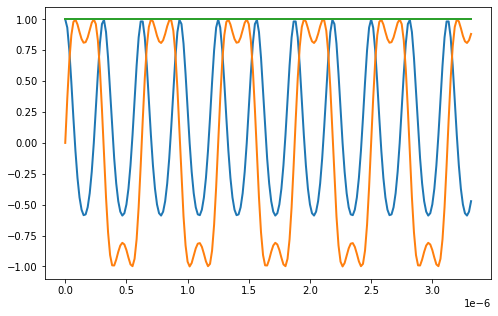

In [5]:
fig, ax = plt.subplots(figsize = (8,5))
m = np.s_[:200]
ax.plot(t[m], s.real[m], lw = 2)
ax.plot(t[m], s.imag[m], lw = 2)
ax.plot(t[m], np.abs(s[m]), lw = 2)

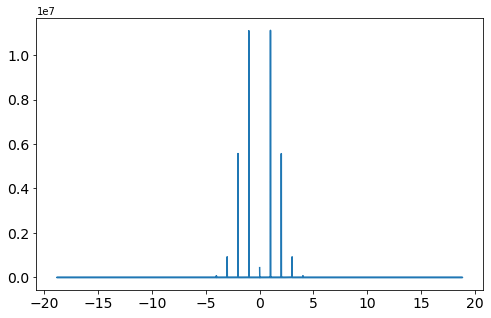

In [6]:
fourier_transform = np.fft.fft(s)
fftfreq = np.fft.fftfreq(len(fourier_transform), np.diff(t)[0])

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(fftfreq*2*np.pi/Γ, np.abs(fourier_transform**2))
set_fontsize(ax, 14)

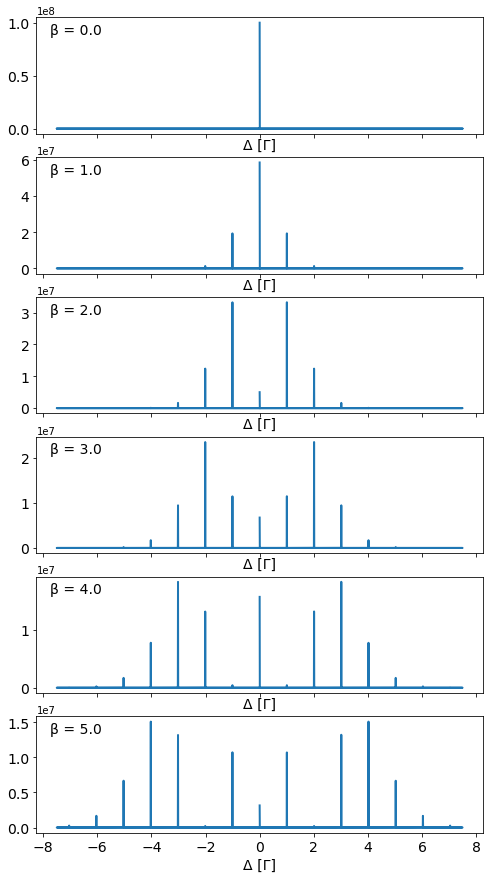

In [7]:
betas = [0,1,2,3,4,5]
fig, axes = plt.subplots(len(betas), figsize = (8,15), sharex = True)

for idx, β in enumerate(betas):
    t = np.linspace(0,100e-6, 10001)
    s = phase_modulation(t,β,ωphase)
    
    fourier_transform = np.fft.fft(s)
    fftfreq = np.fft.fftfreq(len(fourier_transform), np.diff(t)[0])
    fftfreq *= 2*np.pi
    m = np.abs(fftfreq/Γ) < 7.5

    axes[idx].plot(fftfreq[m]/Γ, np.abs(fourier_transform**2)[m], lw = 2)
    
    axes[idx].text(0.03, 0.95, f"β = {β:.1f}", transform = axes[idx].transAxes,
        ha = 'left', va = 'top', fontsize = 14);
    
    axes[idx].set_xlabel("Δ [Γ]")
    
    set_fontsize(axes[idx], 14)

In [8]:
Main.eval("""using Waveforms""")
Main.eval("""using DifferentialEquations""")
Main.eval("""using BenchmarkTools""")
Main.eval("""
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())
""")

<PyCall.jlwrap Logging.ConsoleLogger(Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000a40) open, 0 bytes waiting), Info, Logging.default_metafmt, true, 0, Dict{Any,Int64}())>

In [9]:
Main.eval("""
function square_wave(t::Float64, frequency::Float64, phase::Float64)
    0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ phase))
end
""")

<PyCall.jlwrap square_wave>

In [10]:
Main.eval("""
function phase_modulation(t::Float64, β::Float64, ω::Float64)
    return exp(1im.*β.*sin(ω.*t))
end
""")

<PyCall.jlwrap phase_modulation>

In [66]:
# reading from file
with open('../ode_fun_mu1mu2.jl', 'r', encoding='utf8') as f:
    ode_fun = f.read()

In [67]:
for l in ode_fun.split('\n')[:20]:
    print(l)


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω = p[1]
		Ωᶜ = conj(Ω)
		νp = p[2]
		Ω1 = p[3]
		Ω1ᶜ = conj(Ω1)
		νp1 = p[4]
		Ω2 = p[5]
		νp2 = p[6]
		Ω2ᶜ = conj(Ω2)
		Δ = p[7]
		Plx = square_wave(t, νp, 3.141592653589793)
		Plz = square_wave(t, νp, 0.0)    
		Pm1y = square_wave(t, νp1, 1.0471975511965976)
		Pm1z = square_wave(t, νp1, 4.1887902047863905)
		Pm2y = square_wave(t, νp2, 2.0943951023931953)
		Pm2z = square_wave(t, νp2, 5.235987755982988)
		du[1,1] = 3367347.38920463*ρ[65,65] + 3367525.85757618*ρ[66,66] + 3367704.32982945*ρ[67,67]


In [68]:
ode_fun_new = """
function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tνp = p[2]
\t\tΔ = p[3]
\t\tνp1 = p[4]
\t\tΩ1 = p[5]
\t\tΩ1ᶜ = conj(Ω1)
\t\tνp2 = p[6]
\t\tΩ2 = p[7]
\t\tΩ2ᶜ = conj(Ω2)
\t\tβ = p[8]
\t\tωphase = p[9]
\t\tΩ = p[1] .* phase_modulation(t, β, ωphase)
\t\tΩᶜ = conj(Ω)
\t\tPlx = square_wave(t, νp, 3.141592653589793)
\t\tPlz = square_wave(t, νp, 0.0)  
\t\tPm1y = square_wave(t, νp1, 1.0471975511965976)
\t\tPm1z = square_wave(t, νp1, 4.1887902047863905)  
\t\tPm2y = square_wave(t, νp2, 2.0943951023931953)
\t\tPm2z = square_wave(t, νp2, 5.235987755982988)  
"""

In [69]:
ode_fun_new += '\n'.join(ode_fun.split('\n')[19:])
for l in ode_fun_new.split('\n')[:22]:
    print(l)


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		νp = p[2]
		Δ = p[3]
		νp1 = p[4]
		Ω1 = p[5]
		Ω1ᶜ = conj(Ω1)
		νp2 = p[6]
		Ω2 = p[7]
		Ω2ᶜ = conj(Ω2)
		β = p[8]
		ωphase = p[9]
		Ω = p[1] .* phase_modulation(t, β, ωphase)
		Ωᶜ = conj(Ω)
		Plx = square_wave(t, νp, 3.141592653589793)
		Plz = square_wave(t, νp, 0.0)  
		Pm1y = square_wave(t, νp1, 1.0471975511965976)
		Pm1z = square_wave(t, νp1, 4.1887902047863905)  
		Pm2y = square_wave(t, νp2, 2.0943951023931953)
		Pm2z = square_wave(t, νp2, 5.235987755982988)  
		du[1,1] = 3367347.38920463*ρ[65,65] + 3367525.85757618*ρ[66,66] + 3367704.32982945*ρ[67,67]


In [70]:
# defining the function in Julia
# make function smaller for testing purposes
# ode_fun_new = '\n'.join(ode_fun.split('\n')[1:300])
# ode_fun_new += '\n \t end \n \t nothing \n end'
Main.eval(ode_fun_new)

<PyCall.jlwrap Lindblad_rhs!>

### Generate density matrix

In [71]:
import scipy.constants as cst

def population(J, T, B=6.66733e9, n = 100):
    c = 2*np.pi*cst.hbar*B/(cst.k*T)
    g = lambda J: 4*(2*J+1)
    a = lambda J: -c*J*(J+1)
    Z = np.sum([g(i)*np.exp(a(i)) for i in range(n)])
    return g(J)*np.exp(a(J))/Z

In [72]:
def J_levels(J):
    return 4*(2*J + 1)

def J_slice(J):
    if J == 0:
        return np.s_[0:J_levels(0)]
    else:
        levels = J_levels(np.arange(J+1))
        return np.s_[np.sum(levels[:-1]):np.sum(levels)]

In [73]:
T = 6.3
ρ_ini = np.zeros([67,67], dtype = 'complex')

for J in range(0,4):
    p = population(J, T)
    levels = J_levels(J)
    sl = J_slice(J)
    np.fill_diagonal(ρ_ini[sl, sl], p/levels)

ρ_ini /= np.diag(ρ_ini).sum()

In [74]:
de_main = -0.39444661382277774 # main dipole transition moment

Γ = 1/(100e-9)
Ω =  1*Γ
ωp = Γ
νp = 1e6
νp1 = νp
Ω1 = 2*Γ
νp2 = νp
Ω2 = 2*Γ
β = 3.8
ωphase = 1.5e6*2*np.pi
Δ = 0

Main.Ω = Ω
Main.νp = νp
Main.Ω1 = Ω1
Main.νp1 = νp1
Main.Ω2 = Ω2
Main.νp2 = νp2
Main.Δ = Δ
Main.Γ = Γ
Main.β = β
Main.ωphase = ωphase

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("p = [Ω, νp, Δ, νp1, Ω1, νp2, Ω2, β, ωphase]")

array([1.00000000e+07, 1.00000000e+06, 0.00000000e+00, 1.00000000e+06,
       2.00000000e+07, 1.00000000e+06, 2.00000000e+07, 3.80000000e+00,
       9.42477796e+06])

In [75]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@time Lindblad_rhs!(du, ρ_ini, [Ω, νp, Δ, νp1, Ω1, νp2, Ω2, β, ωphase], 0.)
tmp = 0
""")

Wall time: 20min 3s


0

### Scan Detuning for β = 3.8

In [96]:
detunings = np.arange(-8,8.5, 0.5)*Γ
Ωs = np.array([1,2,3,4])*Ω
Main.params = np.array(np.meshgrid(Ωs, detunings)).T.reshape(-1,2)

In [97]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.6171662207e9, 1.6171662207e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000a40) open, 0 bytes waiting), 0, 0, 0)>

In [98]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [99]:
# μseconds traversal time
(1.5*25.4 * 1e-3)/184 * 1e6

207.06521739130432

In [100]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)

β = 3.8

function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,1]; νp; params[i,2]; νp1; Ω1; νp2 ; Ω2; β; ωphase])
end
""")

<PyCall.jlwrap prob_func>

In [101]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [102]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 2.5e-7, reltol = 2.5e-4)
sim.elapsedTime
""")

291.034927001

In [103]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [104]:
result_scan = np.empty([len(Main.params),67+2], dtype = 'complex')
result_scan[:,:2] = Main.params.copy()
result_scan[:,2:] = ens_u.copy()

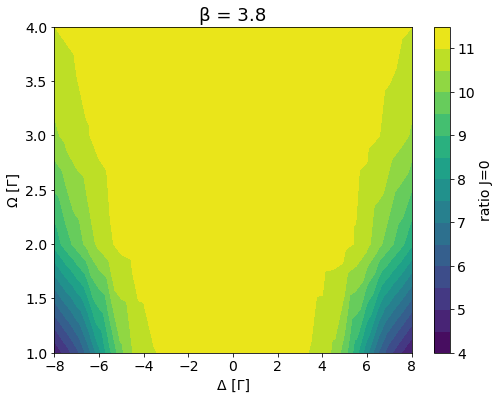

In [115]:
x = result_scan[:,1].real/Γ
y = result_scan[:,0].real/Γ
z = result_scan[:,2:6].sum(axis = 1).real / np.diag(ρ_ini)[:4].sum().real

fig, ax = plt.subplots(figsize = (8,6))
cs = ax.tricontourf(x,y,z, levels = 15)
# cs = ax.tripcolor(x,y,z)

ax.set_xlabel('Δ [Γ]')
ax.set_ylabel('Ω [Γ]')

cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('ratio J=0')

ax.set_title('β = 3.8')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

### Scan Detuning for β = 5

In [188]:
detunings = np.arange(-8,8.5, 0.5)*Γ
Ωs = np.array([1,2,3,4])*Ω
Main.params = np.array(np.meshgrid(Ωs, detunings)).T.reshape(-1,2)

In [189]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.617168869891e9, 1.617168869891e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000a40) open, 0 bytes waiting), 0, 0, 0)>

In [190]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [191]:
# μseconds traversal time
(1.5*25.4 * 1e-3)/184 * 1e6

207.06521739130432

In [192]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)

β = 5

function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,1]; νp; params[i,2]; νp1; Ω1; νp2 ; Ω2; β; ωphase])
end
""")

<PyCall.jlwrap prob_func>

In [193]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [194]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 2.5e-7, reltol = 2.5e-4)
sim.elapsedTime
""")

286.9143088

In [195]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [196]:
result_scan = np.empty([len(Main.params),67+2], dtype = 'complex')
result_scan[:,:2] = Main.params.copy()
result_scan[:,2:] = ens_u.copy()

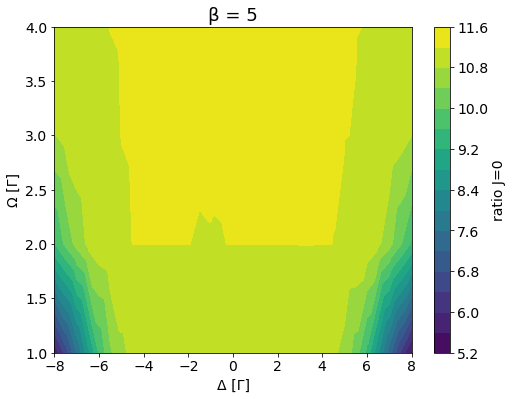

In [204]:
from scipy.stats import binned_statistic_2d

xbins = np.arange(-8, 8.5, 0.5)
ybins = np.arange(1,4+1,1)

x = result_scan[:,1].real/Γ
y = result_scan[:,0].real/Γ
z = result_scan[:,2:6].sum(axis = 1).real / np.diag(ρ_ini)[:4].sum().real

stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)


fig, ax = plt.subplots(figsize = (8,6))
cs = ax.tricontourf(x,y,z, levels = 15)
# cs = ax.tripcolor(x,y,z)
# cs = ax.pcolormesh(X,Y,stat.T, vmin = 4, vmax = 11 

ax.set_xlabel('Δ [Γ]')
ax.set_ylabel('Ω [Γ]')

cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('ratio J=0')

ax.set_title('β = 5')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

### Scan Detuning for β = 0

In [173]:
detunings = np.arange(-8,8.5, 0.5)*Γ
Ωs = np.array([1,2,3,4])*Ω
Main.params = np.array(np.meshgrid(Ωs, detunings)).T.reshape(-1,2)

In [174]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.617168437979e9, 1.617168437979e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000a40) open, 0 bytes waiting), 0, 0, 0)>

In [175]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [176]:
# μseconds traversal time
(1.5*25.4 * 1e-3)/184 * 1e6

207.06521739130432

In [177]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)

β = 0

function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,1]; νp; params[i,2]; νp1; Ω1; νp2 ; Ω2; β; ωphase])
end
""")

<PyCall.jlwrap prob_func>

In [178]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [179]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 2.5e-7, reltol = 2.5e-4)
sim.elapsedTime
""")

302.971379799

In [180]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [181]:
result_scan = np.empty([len(Main.params),67+2], dtype = 'complex')
result_scan[:,:2] = Main.params.copy()
result_scan[:,2:] = ens_u.copy()

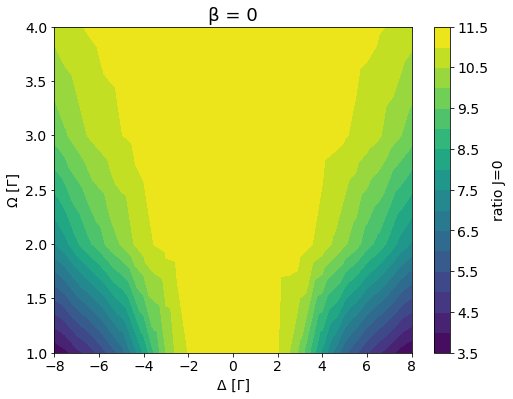

In [182]:
x = result_scan[:,1].real/Γ
y = result_scan[:,0].real/Γ
z = result_scan[:,2:6].sum(axis = 1).real / np.diag(ρ_ini)[:4].sum().real

fig, ax = plt.subplots(figsize = (8,6))
cs = ax.tricontourf(x,y,z, levels = 15)
# cs = ax.tripcolor(x,y,z)

ax.set_xlabel('Δ [Γ]')
ax.set_ylabel('Ω [Γ]')

cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('ratio J=0')

ax.set_title('β = 0')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

### Scan Detuning for β = 3.8

In [205]:
detunings = np.arange(-8,8.5, 0.5)*Γ
Ωs = np.array([1,2,3,4])*Ω
Main.params = np.array(np.meshgrid(Ωs, detunings)).T.reshape(-1,2)

In [206]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.617169373167e9, 1.617169373167e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000a40) open, 0 bytes waiting), 0, 0, 0)>

In [207]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [208]:
# μseconds traversal time
(1.5*25.4 * 1e-3)/184 * 1e6

207.06521739130432

In [209]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)

β = 3.8

function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,1]; 0; params[i,2]; νp1; Ω1; νp2 ; Ω2; β; ωphase])
end
""")

<PyCall.jlwrap prob_func>

In [210]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [211]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 2.5e-7, reltol = 2.5e-4)
sim.elapsedTime
""")

264.199671499

In [212]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [213]:
result_scan = np.empty([len(Main.params),67+2], dtype = 'complex')
result_scan[:,:2] = Main.params.copy()
result_scan[:,2:] = ens_u.copy()

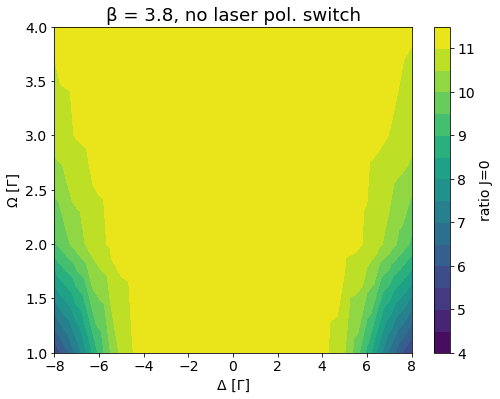

In [239]:
from scipy.stats import binned_statistic_2d

xbins = np.arange(-8, 8.5, 0.5)
ybins = np.arange(1,4+1,1)

x = result_scan[:,1].real/Γ
y = result_scan[:,0].real/Γ
z = result_scan[:,2:6].sum(axis = 1).real / np.diag(ρ_ini)[:4].sum().real

stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)


fig, ax = plt.subplots(figsize = (8,6))
cs = ax.tricontourf(x,y,z, levels = np.linspace(4,11.5,16))
# cs = ax.tripcolor(x,y,z)
# cs = ax.pcolormesh(X,Y,stat.T, vmin = 4, vmax = 11.2)

ax.set_xlabel('Δ [Γ]')
ax.set_ylabel('Ω [Γ]')

cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('ratio J=0')

ax.set_title('β = 3.8, no laser pol. switch')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [237]:
np.linspace(4,11.5,16)

array([ 4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,
        9.5, 10. , 10.5, 11. , 11.5])

In [227]:
0.5*15 +5

12.5